# EpiLearn Demonstration

### Created by Wei Jin and Zewen Liu

Please feel free to reach out with questions or suggestions: wei.jin@emory.edu and zewen.liu@emory.edu

## Introduction

EpiLearn is a Pytorch-based machine learning toolkit for epidemic data modeling and analysis. We provide numerour features including:

* Implementation of Epidemic Models
* Simulation of Epidemic Spreading
* Visualization of Epidemic Data
* Unified Pipeline for Epidemic Tasks

For more details, please check the github page: [EpiLearn (https://github.com/Emory-Melody/EpiLearn)](https://github.com/Emory-Melody/EpiLearn/tree/main?tab=readme-ov-file).

**Remark**: If you like this pacakage, please consider starring us in the GitHub page! Thank you!

## Part0: Install EpiLearn
May take a few minutes; Try running the cell again if failed to install.

In [2]:
# !pip install epilearn==0.0.19
# !pip install torch_geometric
# !pip install torch_scatter -f https://data.pyg.org/whl/torch-2.4.0%2Bcu121.html
import os
os.chdir("..")

## Part1: Building forecasting task with EpiLearn

### Pipeline Overview

#### 0. Import Packages

In [2]:
# from epilearn.models.SpatialTemporal.STGCN import STGCN
from epilearn.models.Temporal import GRUModel
from epilearn.data import UniversalDataset
from epilearn.utils import transforms
from epilearn.tasks import Forecast
import torch

#### 1. Configuration

In [3]:
# initialize settings
lookback = 12 # inputs size
horizon = 3 # predicts size

#### 2. Dataset Loading

To begin with, we need to choose and load data using a UniversalDataset defined by Epilearn.

In [4]:
# # let's use cosine as toy data (we will generate a cosine wave)
# num_samples = 1000
# x = torch.linspace(0, 2 * torch.pi, num_samples)  # Generate 1000 points between 0 and 2π
# cosine_data = torch.cos(x).unsqueeze(1)

# dataset = UniversalDataset(x=cosine_data)

In [5]:
# Load Tycho Dataset
dataset = UniversalDataset(name='Tycho_v1', root='./tmp_data/')
print(dataset.features)

downloading Tycho_v1 Dataset
['DIPHTHERIA', 'HEPATITIS A', 'MEASLES', 'MUMPS', 'SMALLPOX']


In [6]:
# choose one disease
print("Choosing:", dataset.features[1])
dataset.x = dataset.x[1].unsqueeze(1)
dataset.y = dataset.x

Choosing: HEPATITIS A


In [7]:
# Chosen data shape
print(dataset.x.shape) # time steps * channels

torch.Size([2091, 1])


In [8]:
dataset.y.shape

torch.Size([2091, 1])

#### 3. Transformation

Epilearn provides numerous transformations including normalization, seasonal decomposition, converting to frequency domain, etc. The loading of these functions follows similar style to Torch, as shown below.

To customize your own transformation, simply add a new class following the style shown in [Transformations](https://vermillion-malasada-a2864e.netlify.app/html/api/utils#transformation).



In [9]:
# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()], # Normalize the features
                "target":  [transforms.normalize_target()], # Normalize targets
                                    })

dataset.transforms = transformation

In [10]:
transformation

Compose(
    features
    target
)

#### 4. Task Initialization and Model Evaluation
Epilearn currently supports two tasks: Forecast and Detection. The Forecast task takes in a UniversalDataset, model prototype and other configurations like lookback window size and the horizon size. The same setting applies to the Detection task. After initializing, you can try functions like `.train_model()` and `.evaluate_model()` to test the models performance on given datasets.

In [11]:
# Initialize Task
task = Forecast(prototype=GRUModel,
                lookback=lookback,
                horizon=horizon,
                device='cpu')

In [12]:
task

For detailed documentation for the `Forecast` class, please refer to https://epilearn-doc.readthedocs.io/en/latest/API/tasks.html#epilearn.tasks.forecast.Forecast.

In [13]:
# hyperparameters of your model
model_args = {"num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "device": 'cpu'}

# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=40,
                          batch_size=32,
                          train_rate=0.6,
                          val_rate=0.1,
                          lr=1e-3,
                          weight_decay=1e-5,
                          permute_dataset=False,
                          model_args=model_args) # pass the hyperparameters of your model

100%|██████████| 40/40 [00:08<00:00,  4.67it/s]




Final Training loss: 0.09994379717570084
Final Validation loss: 0.3909231722354889
Test MSE: 0.2972174286842346
Test MAE: 0.3885359466075897
Test RMSE: 0.5451765060424805


In [14]:
# Evaluation
evaluation = task.evaluate_model()

Test MSE: 31304.701171875
Test MAE: 126.09528350830078
Test RMSE: 176.9313507080078


## Part2 Case Study: Forecasting Measles infections

#### 0. Import Packages

In [15]:
import torch
from epilearn.models.Temporal import GRUModel
from epilearn.data import UniversalDataset
from epilearn.utils import transforms
from epilearn.tasks import Forecast


#### 1. Configurations

# initialize settings
lookback = 8 # inputs size
horizon = 1 # predicts size

In [16]:
lookback = 8
horizon = 1

#### 2. Loading Datasets

In [17]:
measles_data = UniversalDataset(name='Measles', root='./tmp/')

In [18]:
print('Total data:', measles_data.x)

Total data: tensor([[ 0.,  0.,  0.,  ..., 39., 29.,  2.],
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., 12.,  4., 15.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  ...,  1.,  6.,  9.]])


In [19]:
print('Total regions:', measles_data.features)

Total regions: ['Abingdon', 'Abram', 'Accrington', 'Acton', 'Adlington', 'Adwick.le.Street', 'Aldeburgh', 'Alderley.Edge', 'Aldershot', 'Aldridge', 'Alford', 'Alfreton', 'Alnwick', 'Alreborough', 'Alsager', 'Alton', 'Altrincham', 'Amble', 'Amblecote', 'Ampthill', 'Andover', 'Appleby', 'Arnold', 'Arundel', 'Ashbourne', 'Ashburton', 'Ashby.de.la.Zouch', 'Ashby.Woulds', 'Ashford', 'Ashington', 'Ashton.in.Makerfield', 'Ashton.u.Lyne', 'Aspull', 'Atherton', 'Audenshaw', 'Aylesbury', 'Bacup', 'Baildon', 'Bakewell', 'Baldock', 'Banbury', 'Banstead', 'Barking', 'Barnard.Castle', 'Barnes', 'Barnet', 'Barnoldswick', 'Barnsley', 'Barnstaple', 'Barrow.in.Furness', 'Barrowford', 'Barton.upon.Humber', 'Basingstoke', 'Bath', 'Batley', 'Beaconsfield', 'Bebington', 'Beccles', 'Beckenham', 'Beddlington.and.Wallington', 'Bedford', 'Bedlingtonshire', 'Bedworth', 'Beeston.and.Stapleford', 'Belper', 'Benfleet', 'Bentley.with.Arksey', 'Berkhamsted', 'Berwick.upon.Tweed', 'Beverley', 'Bewdley', 'Bexhill', 'Be

In [20]:
# Choose one region
print('Chosen region:', measles_data.features[100])
measles_data.x = measles_data.x[100].unsqueeze(1)
measles_data.y = measles_data.x
measles_data.features = measles_data.x
measles_data.target = measles_data.x
print('length: ', measles_data.x.shape[0])

Chosen region: Boston
length:  1108


Text(0, 0.5, 'confirmed cases')

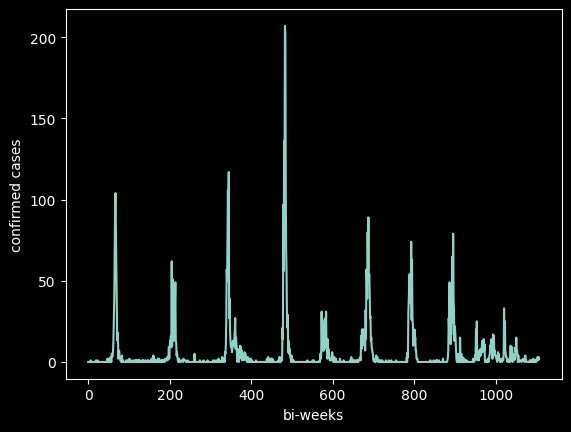

In [21]:
import matplotlib.pyplot as plt
# visualize the data
plt.plot(measles_data.x)
plt.xlabel('bi-weeks')
plt.ylabel('confirmed cases')

#### 3. Apply Transformations

In [22]:
# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_target()]
                })
measles_data.transforms = transformation

#### 4. Build Task and Perform Training & Evaluation

In [23]:
# Initialize Task
task = Forecast(prototype=GRUModel,
                lookback=lookback,
                horizon=horizon,
                device='cuda')

In [24]:
# hyperparameters of your model
model_args = {"num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "device": 'cpu'}

# Training
result = task.train_model(dataset=measles_data,
                          loss='mse',      # loss function; using MSE as default
                          epochs=100,      # training epochs, we can use more epochs to obtain better performance
                          lr=0.01,         # learning rate of the model
                          train_rate=0.6,  # 60% is used for training
                          val_rate=0.2,    # 20% is used for validation; the rest 20% is for testing
                          weight_decay=1e-5,
                          batch_size=32,
                          model_args=model_args,
                          device='cpu')    # Using CPU could be slow though



100%|██████████| 100/100 [00:08<00:00, 12.11it/s]



Final Training loss: 0.1723936473329862
Final Validation loss: 0.3141956627368927
Test MSE: 0.14428283274173737
Test MAE: 0.18328075110912323
Test RMSE: 0.3798457980155945


In [25]:
# Evaluation
evaluation = task.evaluate_model()

Test MSE: 40.89035415649414
Test MAE: 3.085460662841797
Test RMSE: 6.394556522369385


### Visualization

In [26]:
measles_data

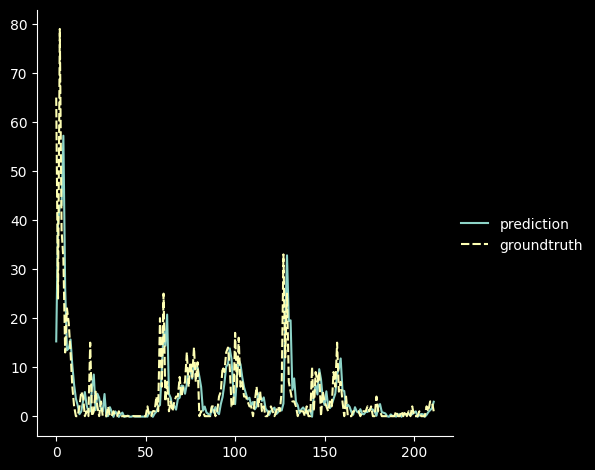

In [27]:
predictions, groundtruth = task.plot_forecasts(task.test_dataset, index_range=(0,-1))

### Applying various temporal models

In [28]:
# To use other popular temporal models, simply import and the change the prototypes in the forecast class
from epilearn.models.Temporal import LSTMModel, CNNModel, DlinearModel

models = {"LSTM": LSTMModel, "DLinear": DlinearModel, "CNN": CNNModel}

In [29]:
for name, model in models.items():
  # Loading new prototype
  print(f"Using {name}")
  task.prototype = model
  # hyperparameters of your model
  model_args = {"num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "device": 'cpu'}
  # Training
  result = task.train_model(dataset=measles_data,
                            loss='mse',   # loss function; using MSE as default
                            epochs=5,    # training epochs (just for testing)
                            lr = 0.01,    # learning rate of the model
                            train_rate=0.6, # 60% is used for training
                            val_rate=0.2, # 20% is used for validation; the rest 20% is for testing
                            weight_decay=1e-4,
                            batch_size=5,
                            model_args=model_args,
                            device="cpu" # Using CPU could be slow
                            )
  # Evaluation
  evaluation = task.evaluate_model()

Using LSTM


100%|██████████| 5/5 [00:02<00:00,  2.42it/s]




Final Training loss: 0.6137007374292641
Final Validation loss: 0.8660793900489807
Test MSE: 0.1400110125541687
Test MAE: 0.19881553947925568
Test RMSE: 0.37418046593666077
Test MSE: 39.67970275878906
Test MAE: 3.34698224067688
Test RMSE: 6.299182891845703
Using DLinear


100%|██████████| 5/5 [00:00<00:00, 18.94it/s]




Final Training loss: 0.37778695082912844
Final Validation loss: 0.20235180854797363
Test MSE: 0.16335034370422363
Test MAE: 0.24362041056156158
Test RMSE: 0.40416622161865234
Test MSE: 46.29417037963867
Test MAE: 4.101254940032959
Test RMSE: 6.803981781005859
Using CNN


100%|██████████| 5/5 [00:00<00:00,  9.04it/s]



Final Training loss: 0.7609848697862948
Final Validation loss: 0.33099523186683655
Test MSE: 0.21609431505203247
Test MAE: 0.307404100894928
Test RMSE: 0.4648594558238983
Test MSE: 61.24203109741211
Test MAE: 5.175028324127197
Test RMSE: 7.825728893280029


### Homework 1

1. Try performing hyperparameter tuning on different temporal models.
2. Try forecasting other diseases in Tycho Dataset.

For more information about the data, please refer to https://github.com/Emory-Melody/EpiLearn/tree/main/datasets.

In [30]:
# Loading more datasets
covid_dataset = UniversalDataset(name='Covid_Brazil', root='./test_downloads/') # (e.g. Covid_'Country'; Supported countries: China, Brazil, Austria, England, France, Italy, Newzealand, Spain)

downloading Covid Static Dataset
downloading Covid Dynamic Dataset


In [31]:
covid_dataset.x.shape # timesteps, regions, channels (pick one region for experiment)

torch.Size([122, 27, 3])

## Part3: Modeling Spatial-Temporal Data

Additionaly, Epilearn provides support for modeling spatial-temporal data with machine learning tools.

Please feel free to check a classic spatiotemporal forecasting task on traffic: https://arxiv.org/pdf/1709.04875

In [32]:
from epilearn.models.SpatialTemporal import STGCN
from epilearn.data import UniversalDataset
from epilearn.utils import transforms
from epilearn.tasks.forecast import Forecast

# initialize settings
lookback = 12 # inputs size
horizon = 3 # predicts size


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]



Final Training loss: 0.6814434826374054
Final Validation loss: 0.8271546363830566


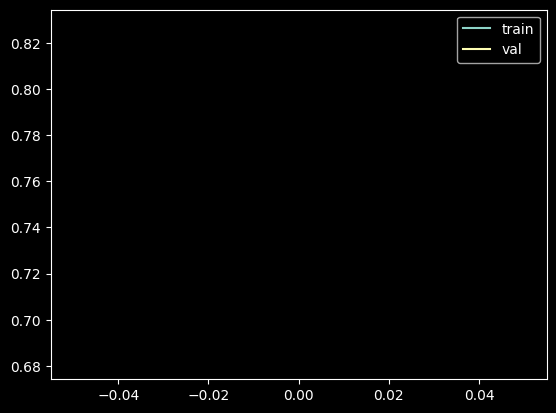

Test MSE: 5.799108982086182
Test MAE: 1.7132432460784912
Test RMSE: 2.4081339836120605
Test MSE: 335363.4375
Test MAE: 205.195068359375
Test RMSE: 579.105712890625


In [35]:
# load toy dataset
dataset = UniversalDataset()
dataset.load_toy_dataset()
# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_target()],
                "graph": [transforms.normalize_adj()]})
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=STGCN, # SpatioTemporal GCN
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')

model_args = {"num_features": 4, "num_nodes": dataset.graph.shape[0], "num_timesteps_input": lookback, "num_timesteps_output": horizon, "device": 'cpu'}
# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=1,
                          train_rate=0.45,
                          val_rate=0.35,
                          batch_size=128,
                          lr=1e-3,
                          weight_decay=1e-3,
                          permute_dataset=True,
                          model_args=model_args,
                          device='cpu')
# Evaluation
evaluation = task.evaluate_model()

## part4: Building your own Deep Learning Model

In [36]:
# let's still use the measles dataset and randomly choose a region
measles_data = UniversalDataset(name='Measles', root='./tmp/')
print('Chosen region:', measles_data.features[105])
measles_data.x = measles_data.x[105].unsqueeze(1)
measles_data.y = measles_data.x
# measles_data.features = measles_data.x
# measles_data.target = measles_data.x
print('length: ', measles_data.x.shape[0])

Chosen region: Bradford
length:  1108


In [37]:
import torch
import torch.nn as nn
from epilearn.models.Temporal.base import BaseModel

class CustomizedTemporal(BaseModel):
    def __init__(self,
                num_features,
                num_timesteps_input,
                num_timesteps_output,
                hidden_size,
                num_layers,
                bidirectional,
                device = 'cpu'):
        super(CustomizedTemporal, self).__init__(device=device)
        self.num_feats = num_features
        self.hidden = hidden_size
        self.num_layers = num_layers
        self.bidirectional=bidirectional
        self.lookback = num_timesteps_input
        self.horizon = num_timesteps_output
        self.device = device
        # use an api of GRU model
        self.gru = nn.GRU(input_size=self.num_feats, hidden_size=self.hidden, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(self.hidden, self.horizon)

    def forward(self, feature, graph=None, states=None, dynamic_graph=None, **kargs):
        # Forward propagate GRU
        out, _ = self.gru(feature)  # out: tensor of shape (batch, seq_length, hidden_size * num_directions)

        # Decode the last hidden state
        out = self.fc(out[:, -1, :])

        return out

    def initialize(self):
        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

In [40]:
# initialize settings
lookback = 64 # inputs size
horizon = 1 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()]
                })
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=CustomizedTemporal,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')


# hyperparameters of your model
model_args = {"num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "hidden_size": 32, "num_layers": 1, "bidirectional": False, "device": 'cpu'} # this should correspond to your __init__ function input

# Training
result = task.train_model(dataset=measles_data,
                          loss='mse',
                          epochs=1,
                          batch_size=32,
                          train_rate=0.6,
                          val_rate=0.2,
                          lr=1e-3,
                          weight_decay=1e-5,
                          permute_dataset=False,
                          model_args=model_args, # pass the hyperparameters of your model
                          device='cpu',
                          verbose=False
                          )

100%|██████████| 1/1 [00:00<00:00,  7.62it/s]



Final Training loss: 9086.499010587993
Final Validation loss: 6742.09912109375
Test MSE: 4528.150390625
Test MAE: 50.214324951171875
Test RMSE: 67.29153442382812


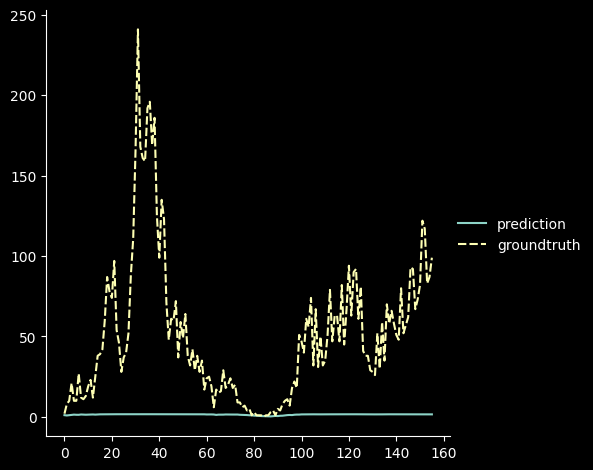

In [41]:
forecasts = task.plot_forecasts(task.test_dataset, index_range=[0,-1])

### Homework 2

1. Play with the given example and figure out the input and output of the customized model.
2. Build a new CustomizedModel based on your own knowledge

For more information about the data, please refer to https://github.com/Emory-Melody/EpiLearn/blob/main/examples/model_customization.ipynb.

## Part5: Data Simulation

In this section, we provide a tutorial of the simulation methods in EpiLearn. In general, we focus on the simulation of static and dynamic properties including graph structure and node features.


### 0. Import Packages

In [42]:
import torch
from epilearn.models.SpatialTemporal import NetSIR
from epilearn.models.Temporal import SIR, SIS, SEIR
from epilearn.utils import utils, simulation
from epilearn import visualize

### Temporal Simulation

At the starting time point, we initilize the number of people's states in the region: Suspected, Infected, and Recovered.

SIR model assumes the transmission dynamics using the following differential equations:
* $ \frac{dS}{dt} = -\beta \frac{SI}{N} $
  
*  $ \frac{dI}{dt} = \beta \frac{SI}{N} - \gamma I $
  
*  $ \frac{dR}{dt} = \gamma I $
  
The $\beta$ and $\gamma$ represent **infection rate** and **recovery rate** respectively.

In [43]:
data = torch.zeros(3)
data.data[0] = 3416 # Initial Suspected
data.data[1] = 210  # Initial Infected
data.data[2] = 65   # Initial Recovered
data = data.float()
print("Initial States: ", list(data.numpy()))

Initial States:  [3416.0, 210.0, 65.0]


In [44]:
# Initialize the model (predicting 100 steps ahead with predefined infection rate and recovery rate)
model = SIR(horizon=200, infection_rate=0.1, recovery_rate=0.0384)

In [45]:
# Predict
preds = model(data, steps = None) # steps = None or horizon

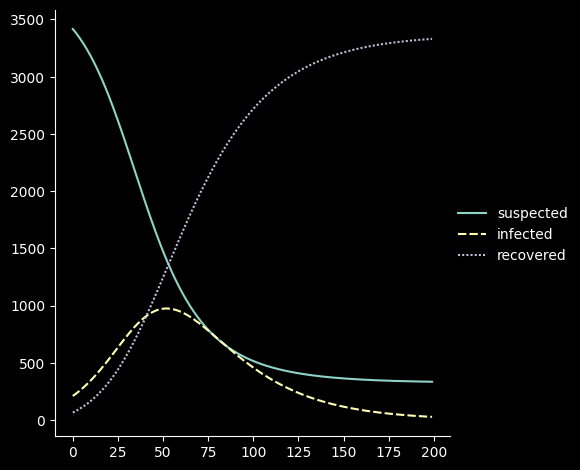

In [46]:
# visualization
visualize.plot_series(preds, columns = ['suspected', 'infected', 'recovered'])

### Homework 3

1. Get the time of the infection peak.
2. Explore the relations between infection rate and the time of the infection peak.

infection peak at 52


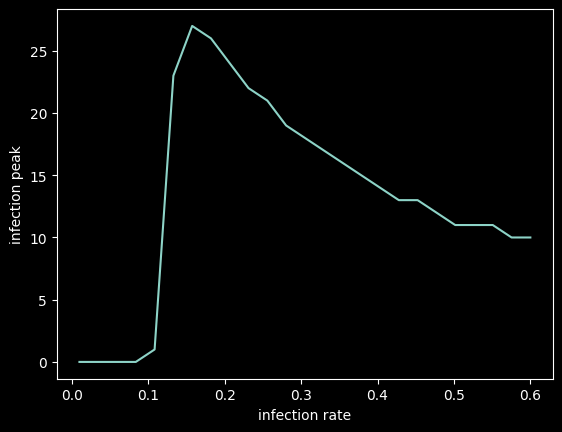

In [47]:
# infection peak
print(f"infection peak at {preds[:,1].argmax().item()}")

# infection rate vs infection peak

infection_rates = torch.linspace(0.01, 0.6, 25)
recovery_rate = 0.1
peak_times = []
for infection_rate in infection_rates:
    model = SIR(horizon=200, infection_rate=infection_rate, recovery_rate=recovery_rate)
    preds = model(data, steps = None)
    peak_times.append(preds[:,1].argmax().item())

import matplotlib.pyplot as plt
plt.plot(infection_rates, peak_times)
plt.xlabel('infection rate')
plt.ylabel('infection peak')
plt.show()


### Spatial-Temporal Simulation

For Spatial-Temporal Simulation, we initialze a random graph first and then manually set a subset of nodes to be infected while the others are assumed to be suspected.

After initialization, we apply a spatial-temporal simulation model: **Network SIR** to get the infection results in the given time steps.

### 1. Generate random static graph

In [48]:
# generate random static graph
initial_graph = simulation.get_random_graph(num_nodes=25, connect_prob=0.20)

In [49]:
initial_states = torch.zeros(25,3) # [S,I,R]
initial_states[:, 0] = 1 # set all nodes' initial states to be 'Suspected'
# set infected individual: No.3 and No.10
initial_states[3, 0] = 0
initial_states[3, 1] = 1

initial_states[10, 0] = 0
initial_states[10, 1] = 1

### 2. Initialize NetworkSIR model and perform simulation based on the generated inital graph

In [50]:
# Initialize the model and perform simulation
model = NetSIR(num_nodes=initial_graph.shape[0], horizon=120, infection_rate=0.05, recovery_rate=0.05) # predicting 120 steps
preds = model(initial_states, initial_graph, steps = None)

### 3. Plot simulation result at a certain time point

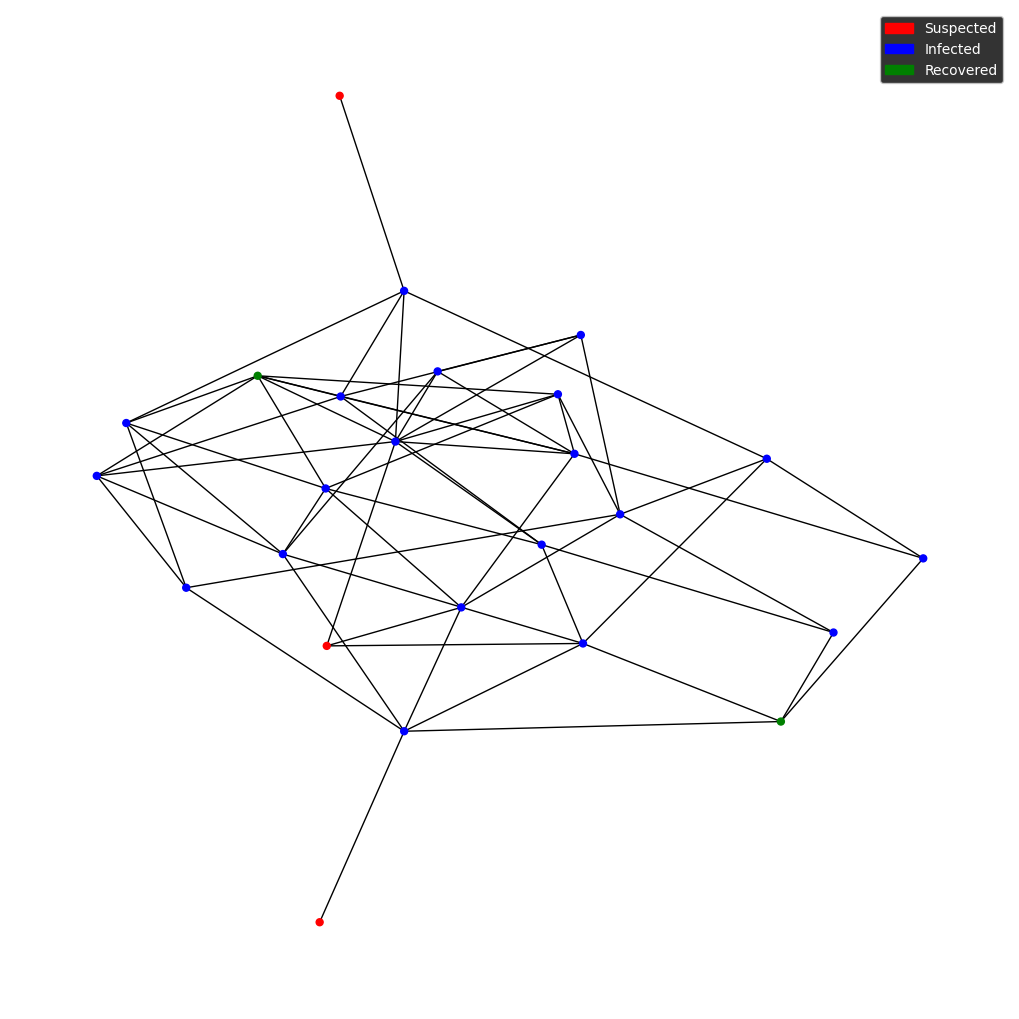

In [51]:
time_step = 17 # visualize a slice of the simulation
states = preds.argmax(2)[time_step].detach().numpy() # states at slice t
graph = initial_graph.to_sparse().indices().detach().numpy()

layout = visualize.plot_graph(states, graph, classes=['Suspected', 'Infected', 'Recovered'])

### Homework 3

1. Plot the total number of infections over time. See how the numbers of infected, suscepted and recovered change.
2. Get the time of the infection peak across the entire graph.
3. Try changing the simulation graph size and connection density. Explore the relations between connectivity and the infection peak.

### More Simulation Models

Beyond the simulation models mentioned above, Epilearn also provides the following:

* **Gravity Model**.  The gravity model is used to simulate the interaction between nodes based on their attributes and distance. It is often used in spatial analysis. For example, in epidemic, it can be used to capture the regional contact and transmission patterns invoked by human mobility.
  - Check out [our documentation here](https://epilearn-doc.readthedocs.io/en/latest/tutorials/simulation.html#gravity-model)
* **Mobility Simulation**. Mobility simulation models the movement of nodes over time, which can represent entities such as people or vehicles in a network.
  - Check out [our documentation here](https://epilearn-doc.readthedocs.io/en/latest/tutorials/simulation.html#mobility-simulation)

## Part6: Finding Patient-Zero with Graph Neural Networks

**Overall Goal:** Given the current infection states on a graph—where nodes represent locations or individuals—predict the original source of the infection.

Reference Material: https://ojs.aaai.org/index.php/AAAI/article/view/26152

In [1]:
import torch
import os
import matplotlib.pyplot as plt
os.chdir("..")

from epilearn.models.SpatialTemporal.STGCN import STGCN

from epilearn.models.Spatial.GCN import GCN
from epilearn.models.Spatial.SAGE import SAGE
from epilearn.models.Spatial.GAT import GAT
from epilearn.models.Spatial.GIN import GIN

from epilearn.data import UniversalDataset
from epilearn.utils import utils, transforms
from epilearn.utils import simulation
from epilearn.tasks.detection import Detection
from epilearn.models.SpatialTemporal.NetworkSIR import NetSIR

TypeError: unsupported operand type(s) for |: 'type' and 'NoneType'

In [2]:
# create a simulation dataset with NetSIR
num_nodes = 25
future_length=25 # Use 25 timesteps after the outbreaks
# generate random static graph: 25 nodes
initial_graph = simulation.get_random_graph(num_nodes=num_nodes, connect_prob=0.15)
initial_states = torch.zeros(num_nodes,3) # [S,I,R]
initial_states[:, 0] = 1

# create 500 samples
graph = initial_graph
x = []
y = [] # Target will be 0 or 1 (not patient zero or patient zero)
for i in range(500):
    # set infected individual randomly
    idx = torch.randint(0,num_nodes, (1,))
    current_initial_states = initial_states.clone() # Clone initial_states for each sample
    current_initial_states[idx.item(), 0] = 0
    current_initial_states[idx.item(), 1] = 1

    model = NetSIR(num_nodes=initial_graph.shape[0], horizon=100, infection_rate=0.01, recovery_rate=0.0384) # infection_rate, recover_rate, fixed_population
    preds = model(current_initial_states, initial_graph, steps = None) # final state after 100 days
    x.append(torch.nn.functional.one_hot(preds[-future_length:].argmax(-1))) # Use last 25 timesteps
    # The target is a binary label for each node: 1 if it's the patient zero, 0 otherwise
    target_labels = torch.zeros(num_nodes, dtype=torch.long)
    target_labels[idx.item()] = 1
    y.append(target_labels)

x = torch.stack(x).float()
y = torch.stack(y).long()
print(x.shape) # num_samples, num_future_states, num_nodes, num_state
print(y.shape) # num_samples, num_nodes

dataset = UniversalDataset(x=x,y=y,graph=initial_graph)

torch.Size([500, 25, 25, 3])
torch.Size([500, 25])


In [3]:
# Adding Transformations. here we only normalize the graph
transformation = transforms.Compose({
                "graph": [transforms.normalize_adj()]})
dataset.transforms = transformation

In [4]:
# Build a customized spatio-temporal model (no torch_geometric)
import torch
from torch import nn

from epilearn.models.SpatialTemporal.base import BaseModel

class SimpleGCNConv(nn.Module):
    """GCN layer with \hat{A}=A+I, D^{-1/2}\hat{A}D^{-1/2} normalization."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.zeros(out_channels))

    def forward(self, x, adj):
        """
        x:   (B, N, Fin)
        adj: (N, N) or (B, N, N)
        """
        if adj.dim() == 2:
            I = torch.eye(adj.size(0), device=adj.device, dtype=adj.dtype)
            A = adj + I
            D = torch.clamp(A.sum(-1), min=1e-12)
            D_inv_sqrt = D.pow(-0.5)
            A_norm = D_inv_sqrt.unsqueeze(-1) * A * D_inv_sqrt.unsqueeze(-2)  # (N,N)
            x = A_norm @ x  # (N,N) @ (B,N,Fin) -> (B,N,Fin)
        else:
            I = torch.eye(adj.size(-1), device=adj.device, dtype=adj.dtype).unsqueeze(0)
            A = adj + I
            D = torch.clamp(A.sum(-1), min=1e-12)
            D_inv_sqrt = D.pow(-0.5)
            A_norm = D_inv_sqrt.unsqueeze(-1) * A * D_inv_sqrt.unsqueeze(-2)  # (B,N,N)
            x = torch.matmul(A_norm, x)  # (B,N,N) @ (B,N,Fin) -> (B,N,Fin)
        return self.lin(x) + self.bias


class CustomizedSpatial(BaseModel):
    def __init__(self,
                 num_nodes,
                 num_features,
                 num_timesteps_input,
                 num_timesteps_output,
                 hidden_size,
                 device='cpu'):
        super().__init__(device=device)
        self.num_nodes = num_nodes
        self.num_feats = num_features
        self.hidden = hidden_size
        self.lookback = num_timesteps_input
        self.horizon = num_timesteps_output
        self.device = device

        self.gcn = SimpleGCNConv(in_channels=self.num_feats * self.lookback,
                                 out_channels=self.hidden)
        # Adjust the output size to match the target shape for the detection task
        self.fc = nn.Linear(self.hidden, 2)

    def forward(self, feature, graph, states=None, dynamic_graph=None, **kargs):
        """
        feature: (B, N, T_in, F) or (B, N, F*T_in) — will be reshaped
        graph:   (N, N) or (B, N, N) adjacency (0/1 or weighted)
        """
        B = feature.shape[0]
        x = feature.reshape(B, self.num_nodes, self.lookback * self.num_feats)  # (B,N,Fin)
        x = self.gcn(x, graph)                         # (B,N,H)
        out = self.fc(x)                               # (B,N,2)
        return out

    def initialize(self):
        pass

Model Initialized!


100%|██████████| 200/200 [00:02<00:00, 85.40it/s]





Final Training loss: 0.1673913460969925
Final Validation loss: 0.16751396656036377


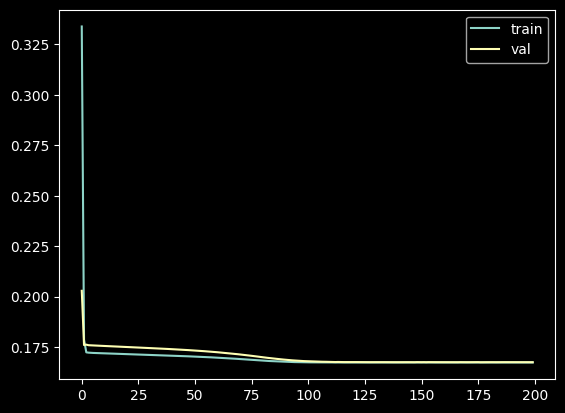

Test ACC: 0.9599999785423279


In [5]:
from epilearn.tasks.detection import Detection

lookback = future_length # future states length
horizon = 2 # target category: 0 for non-infected and 1 for patient-zero

task = Detection(prototype=CustomizedSpatial, dataset=dataset, lookback=lookback, horizon=horizon, device='cpu')

model_args = {"num_nodes": num_nodes, "num_features": 3, "num_timesteps_input": lookback, "num_timesteps_output": horizon, "hidden_size": 16, "device": 'cpu'}

result = task.train_model(dataset=dataset,
                          loss='ce', # cross-entropy loss
                          epochs=200,
                          train_rate=0.6,
                          val_rate=0.2,
                          batch_size=12,
                          lr=1e-3,
                          permute_dataset=False,
                          model_args=model_args
                          )

In [6]:
eval_result = task.evaluate_model()

ACC: 0.9599999785423279


In [7]:
eval_result

{'acc': tensor(0.9600),
 'predictions': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'targets': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1]])}

### Homework 4:
1. Play with the example dataset and model, and figure out the input and output shapes of the model.
2. Trying building your own model!
(torch_geometric provides various GNN convolutions: https://pytorch-geometric.readthedocs.io/en/2.5.1/modules/nn.html#convolutional-layers)